In [ ]:




# Define data transformations
transform = transforms.Compose([
    #ViolaJonesFaceCrop(),
    transforms.RandomHorizontalFlip(p=0.5),
    #----transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0)),
    #----transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #----transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    #----transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #----transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0.4),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
        

Epoch 1/2, Training Loss: 2.8249, Training Accuracy: 62.92%
Validation Loss: 0.6262, Validation Accuracy: 75.56%
Epoch 2/2, Training Loss: 0.6242, Training Accuracy: 73.75%
Validation Loss: 0.5918, Validation Accuracy: 75.56%
Validation EER: 0.4778, EER Threshold: -0.3028
Testing AUC: 0.5975
Testing HTER: 0.3650


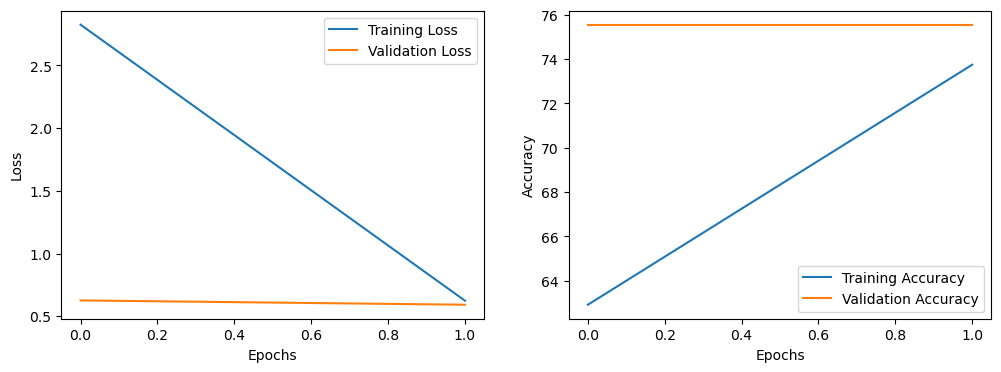

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import cv2
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
torch.manual_seed(0)
random.seed(0)

"""
class ViolaJonesFaceCrop(object):
    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    def __call__(self, image):
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        faces = self.face_cascade.detectMultiScale(image_cv, 1.1, 4)

        # If a face is detected, crop the image to only include the face
        if len(faces) > 0:
            x, y, w, h = faces[0]
            image_cv = image_cv[y:y+h, x:x+w]

        image = F.to_pil_image(image_cv)

        return image
"""
            
# Define data transformations
transform = transforms.Compose([
    #ViolaJonesFaceCrop(),
    transforms.RandomHorizontalFlip(p=0.5),
    #----transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0)),
    #----transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #----transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    #----transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #----transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0.4),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the root directory where your data is organized by folders
train_data_dir = './CASIA_dataset/training set'
validation_data_dir = './CASIA_dataset/testing set'
test_data_dir = './REPLAY_ATTACK/test'

# Create ImageFolder datasets and data loaders
batch_size = 16
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
validation_dataset = datasets.ImageFolder(validation_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_data_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define your CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 56 * 56, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

#  model
model = CNNModel(num_classes=len(train_dataset.classes))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.2) ###

# Training loop
num_epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store training and validation loss
train_losses = []
val_losses = []

# Lists to store training and validation accuracy
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    scheduler.step() ###

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    val_scores, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Store validation scores and labels for EER calculation
            val_scores.extend(outputs[:, 1].cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate validation loss and accuracy
    val_loss = val_loss / len(validation_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print and plot training and validation results
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Calculate Equal Error Rate (EER) on the validation set
fpr, tpr, thresholds = roc_curve(val_labels, val_scores, pos_label=1)
eer_threshold = thresholds[np.argmin(np.abs(tpr - (1 - fpr)))]
eer = 1 - tpr[np.argmin(np.abs(tpr - (1 - fpr)))]
print(f'Validation EER: {eer:.4f}, EER Threshold: {eer_threshold:.4f}')

# Testing set evaluation
test_scores, test_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_scores.extend(outputs[:, 1].cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate AUC on the testing set
fpr_test, tpr_test, thresholds_test = roc_curve(test_labels, test_scores, pos_label=1)
auc_test = auc(fpr_test, tpr_test)
print(f'Testing AUC: {auc_test:.4f}')

# Calculate Half Total Error Rate (HTER) on the testing set using the EER threshold
test_scores = np.array(test_scores)
test_labels = np.array(test_labels)

false_accepts = np.sum((test_scores >= eer_threshold) & (test_labels == 0))
false_rejects = np.sum((test_scores < eer_threshold) & (test_labels == 1))

hter = 0.5 * (false_accepts / np.sum(test_labels == 0) + false_rejects / np.sum(test_labels == 1))
print(f'Testing HTER: {hter:.4f}')

# Plot the training and validation curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()